# Model NEATM + REFLECT MODEL @python3.8
$D_{eff}=\frac{1329\times10^{-H_v/5}}{\sqrt{p_v}}$
$p_v=\frac{A_B}{q}$
$q_s=\frac{F_{sun}}{d^2}$
$T_{fit}=[\frac{(1-A)F_{sun}}{\eta\epsilon\sigma d}]^{1/4}$
$T=T(\theta,\phi)=T_{fit}\cos^{1/4}\theta\cos^{1/4}\phi,(-\frac{\pi}{2}<\theta<\frac{\pi}{2},-\frac{\pi}{2}<\phi<\frac{\pi}{2})$
$F_\lambda=F(\Delta,d,\alpha|\eta,D)$

$F_\lambda=\frac{\epsilon D^2}{2\Delta ^2}\frac{\pi h c^2}{\lambda ^5}\int_{-\pi/2}^{\pi/2}d\phi\int_{\alpha-\pi/2}^{\pi/2}\frac{1}{exp(\frac{hc}{\lambda kT(\theta,\phi)}-1)}\cos^2 \phi\cos(\alpha-\theta)d\theta$

$F_\lambda=\frac{\epsilon D^2}{4\Delta ^2}\int_{-\pi/2}^{\pi/2}d\phi\int_{\alpha-\pi/2}^{\pi/2}\pi B(T,\lambda)\cos^2 \phi\cos(\alpha-\theta)d\theta$


# MCMC_NEATM

## define const & import

In [125]:
#import
import numpy as np
import matplotlib.pyplot as plt
import math as mh 
import pandas as pd
from tqdm import tqdm
import os
from NEATM import *
#constant
Fsun = 1367.5           # sun constant
sigma = 5.67E-8         #stefan-boltzmann constant
h = 6.626007015E-34     #plank constant
#q = 0.29+0.684*0.15    #phase integral = 0.29+0.684*G(=0.15)
epsi = 0.9             #radiance epsilon
kB = 1.38064852E-23     #boltzmann constant  j/k
cl = 299792458.0        #lightspeed m/s
au = 149597870700.0
pi = 3.1415926535
Rsun = 0.00465*au   #Rsun *m
Tsun = 5778         #Tsun  K
Hv = 21.5
G = 0.15
Ndd = 15
lamdai = [3.4,4.6,12,22]

## define MODEL FUNCTION
initial x:flux = delta, it will change "delta"!
list: a,b
a = b
a = b[:]

### Model hhq

In [126]:
def neatm_ohhq(Ndd,eta,D,delta,dd,alpha,lamda,A):   
    summ = 0.
    a = alpha-pi/2
    b = pi/2
    c = -pi/2          
    d = pi/2
    Tfit = np.power((1-A)*Fsun/(eta*epsi*sigma*dd*dd),0.25)
    #print(f"Tss = {Tfit-273}\n")
    dxdy = ((b-a)*(d-c)/(Ndd*Ndd)) 
    for j in range(Ndd):
        for i in range(Ndd):
            phii = (c+(d-c)*j/Ndd)
            thei = (a+(b-a)*i/Ndd)
            T = Tfit*np.power(np.cos(thei),0.25)*np.power(np.cos(phii),0.25)
            integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
            summ = summ + dxdy*integral
    F = (epsi*np.power(D,2)*pi*h*cl*cl)*summ/(2*np.power(delta*au,2)*np.power(lamda,5))
    F = F*(lamda)**2/cl*1e29
    return F
def Model_neatm_Ref_jhx(theta,x,lamda):
    '''
    theta = (eta,D,wf)
    x = (astp,obsp)
    x = (3.4x;4.6x;12x;22x)
    '''
    eta,D,wf = theta
    astp,obsp = x
    lamda1,lamda2,lamda3,lamda4 = lamda
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    #initial
    nn = len(astp[0])
    qutn = int(nn/4)
    flux = np.zeros(nn)
    #w1,w2 with Ref
    for i in range(qutn):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,lamda1,eta,A)
        flux[i] = fluxi + wf*frLambi + frLommi
    for i in range(qutn,qutn*2):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,lamda2,eta,A)
        flux[i] = fluxi + wf*frLambi + frLommi
    #w3,w3 without Ref
    for i in range(qutn*2,qutn*3):
        flux[i] = get_flux_noref(astp[i],obsp[i],D,lamda3,eta,A)
    for i in range(qutn*3,qutn*4):
        flux[i] = get_flux_noref(astp[i],obsp[i],D,lamda4,eta,A)
    return flux
    
def Model_neatm_ohhq(theta,x,lamda):
    eta,D = theta
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    #initial flux
    flux = np.zeros(len(delta))
    nn = int(len(flux))
    for i in range(0,(int(nn/2))-1):
        flux[i] = neatm_ohhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda1*1e-6,A)
    for i in range(int(nn/2),nn):
        flux[i] = neatm_ohhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda2*1e-6,A)
    return flux

### Model reflect

In [127]:
import NEATM
# -*- coding: utf-8 -*-
from re import DOTALL
import matplotlib as mpl
from numpy import *
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from scipy import integrate
from matplotlib.ticker import FuncFormatter
import NEATM
from NEATM import *
# #loading position files:
wlen = np.loadtxt('ObsWLs.txt')
epoch = np.loadtxt('ObsECs.txt')
#fobs = np.loadtxt('fobs.txt')
w12 = np.loadtxt('w12_2010co1.txt')
w34 = np.loadtxt('w34_2010co1.txt')
w1 = w12[0:32]
w2 = w12[32:64]
w3 = w34[0:32]
w4 = w34[32:64]
fobs = np.zeros((len(w1)*4,3))
for i in range(0,len(w1)):
    fobs[i*4+0,0:3] = [3.4,w1[i],w1[i]*0.1]
    fobs[i*4+1,0:3] = [4.6,w2[i],w2[i]*0.1]
    fobs[i*4+2,0:3] = [11.98,w3[i],w3[i]*0.1]
    fobs[i*4+3,0:3] = [22.0,w4[i],w4[i]*0.1]


def para_fit(yita,Dia,wf,A,epoch,wlen):
    flux = []
    frLamb = []
    frLomm = []
    w_final = []
    for i in range(0,len(wlen)):
        astp = epoch[i,0:3]
        obsp = epoch[i,3:6]
        for j in range(0,len(wlen[0,:])):
            wl = wlen[i,j]
            if wl != 0:
                #print(wl,astp,obsp)
                ff = get_flux_ref(astp,obsp,Dia,wl,yita,A) #flux and reflected sunlight
                print(f'f={ff},astp={astp},wl={wl}')
                flux.append(ff[0])
                frLamb.append(ff[1])
                frLomm.append(ff[2])
                w_final.append(wl)
    flux = np.array(flux)
    frLamb = np.array(frLamb)
    frLomm = np.array(frLomm)
    fref = wf * frLamb + frLomm
    w_final = np.array(w_final)
    return flux,fref,w_final

# for i in range(len(fobs)-1,-1,-1):
#     if fobs[i,0] == 3.4 or fobs[i,0]== 4.6:
#         fobs = np.delete(fobs,i,axis=0)

chiall = []  
Dall = []
yita_all = []
for wf in range(0,11):
    wf = wf * 0.05
    for D in range(280,500,10):
        #variables---------------------------------------------------------------------------
        #slope parameter:
        G = 0.15
        #abs magnitude
        mag = 21.5
        #geometric albedo:
        pv = (1329*10**(-mag/5)/D*1000)**2
        #phase integral
        qph = 0.15 + 0.684 * G
        #bond albedo
        A = pv * qph
        for yita in range(80,450,5):
            yita = yita * 0.01
            fm,fref,wfinal = para_fit(yita,D,wf,A,epoch,wlen)
            chi2 = 0
            for i in range(0,len(fm)):
                chi2 = chi2 +  ((fm[i]+fref[i] - fobs[i,1])/(fobs[i,1]*0.1))**2
            #chi2 = 1/(len(wlen)*2-3) * sum(((fm - fobs[:,1])/(fobs[:,1]*0.1))**2)
            chi2 = chi2/(len(fobs)-3)
            chiall.append(chi2)
            print(chi2,D,yita,wf)
            break 
        break
    break
chiall = np.array(chiall)
n = np.where(chiall == chiall.min())
'''
k = 0
chif = []
d1 = []
yita1 = []
for nw in range(0,11):
    for i in range(280,500,10):
        for j in range(80,450,5):
            k = k + 1
            if chiall[k-1] <= chiall.min() + 1:
                d1.append(i+10)
                yita1.append((j+1)*0.05)
            if k == n[0]:
                #print(i,j)
                nnw = nw
                nd = i
                ny = j
                
D_final = nd + 10
yita_final = (ny + 5) * 0.01
nw_final = (nnw+1) * 0.05
pv_final = (1329*10**(-mag/5)/D_final*1000)**2
A_final = pv_final * qph

flux_final,fref,w_final = para_fit(yita_final,D_final,nw_final,A_final,epoch,wlen)'''


f=(0.2574311283637495, 0.0035577239388749266, 0.005931999601044901),astp=[-0.5339575   0.90480846  0.36328469],wl=3.4
f=(1.9370469250859037, 0.0021602789184596003, 0.003601958415722533),astp=[-0.5339575   0.90480846  0.36328469],wl=4.6
f=(21.46331161134894, 0.00037906848178934706, 0.00063204287948609),astp=[-0.5339575   0.90480846  0.36328469],wl=12.0
f=(18.490677395592897, 0.00011838006281826987, 0.00019738194909853425),astp=[-0.5339575   0.90480846  0.36328469],wl=22.0
f=(0.6895896706897547, 0.008429362518723725, 0.022050244107269825),astp=[-0.77958501  0.63253017  0.22746359],wl=3.4
f=(4.782467415091953, 0.005118377495869152, 0.013389087604949673),astp=[-0.77958501  0.63253017  0.22746359],wl=4.6
f=(46.86120300173164, 0.0008981319819421097, 0.0023494101005123295),astp=[-0.77958501  0.63253017  0.22746359],wl=12.0
f=(39.28927025612501, 0.0002804794530516734, 0.0007337020318114551),astp=[-0.77958501  0.63253017  0.22746359],wl=22.0
f=(0.689594646443694, 0.008429414980681832, 0.0220504

'\nk = 0\nchif = []\nd1 = []\nyita1 = []\nfor nw in range(0,11):\n    for i in range(280,500,10):\n        for j in range(80,450,5):\n            k = k + 1\n            if chiall[k-1] <= chiall.min() + 1:\n                d1.append(i+10)\n                yita1.append((j+1)*0.05)\n            if k == n[0]:\n                #print(i,j)\n                nnw = nw\n                nd = i\n                ny = j\n                \nD_final = nd + 10\nyita_final = (ny + 5) * 0.01\nnw_final = (nnw+1) * 0.05\npv_final = (1329*10**(-mag/5)/D_final*1000)**2\nA_final = pv_final * qph\n\nflux_final,fref,w_final = para_fit(yita_final,D_final,nw_final,A_final,epoch,wlen)'

## read data file

#### 处理原始数据 将坐标垂直叠加，方便直接计算12，22微米的流量

In [128]:
namelist = ['2003MA3','2010CO1','2010DG77','2010EX11','2010FC81','2010FH81','2010GS7','2010JN71','2010KX7','2010PW58','2010XP69','2019DD2']
name = '2010co1'

#### read data & cal  
$x\equiv \Delta,d,\alpha$

In [129]:
obsec = np.loadtxt(f'newepoch_{name}.txt')
name = namelist[1].lower()
obsec = np.loadtxt(f'newepoch_{name}.txt')
obsdat12 = np.loadtxt(f'w12_{name}.txt')
obsdat34 = np.loadtxt(f'w34_{name}.txt')
#ast-sun
d_N = np.sqrt(obsec[:,0]**2+obsec[:,1]**2+obsec[:,2]**2)
#print('ast-sun',d_N)
#ast-earth
delta_N = np.sqrt((obsec[:,3]-obsec[:,0])**2+(obsec[:,4]-obsec[:,1])**2+(obsec[:,5]-obsec[:,2])**2)
#print('ast-earth',delta_N)
#earth-sun
dd_N = np.sqrt(obsec[:,3]**2+obsec[:,4]**2+obsec[:,5]**2)
#print('earth-sun',dd_N)
#alpha
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
#print("alpha",alpha_N/pi*180,'\n')
x = (delta_N,d_N,alpha_N)
x1 = np.hstack((obsec[:,0:3],obsec[:,0:3]))
x2 = np.hstack((obsec[:,3:6],obsec[:,3:6]))
x_jhx = (x1,x2)

In [130]:
Dtest = 346
pv = (1329*pow(10,-Hv/5)/(Dtest*0.001))**2
q = 0.29+0.684*G
At = q*pv
fluxi,frLambi,frLommi = get_flux_ref(x_jhx[0][0],x_jhx[1][0],346,3.4,1.2,A)
print(fluxi)
print(Model_neatm_Ref_jhx((1.2,346,0.2),x_jhx,lamdai))

0.21025424634563547


NameError: name 'get_flux_noref' is not defined

##### plot $F_v^{ref}-\lambda$

In [88]:
astp,obsp = obsec[:,0:3],obsec[:,3:6]
delta0,d0,alpha0 = x[0][0],x[1][0],x[2][0]
arraylam = np.linspace(0,22,100)
#refledF = NEATM.get_flux_ref(346,delta0,d0,alpha0,arraylam*1e-6,0.9)
Dtest = 346
pv = (1329*pow(10,-Hv/5)/(Dtest*0.001))**2
q = 0.29+0.684*G
At = q*pv
refledF = NEATM.get_flux_ref(astp[0],obsp[0],Dtest,3.4,1.2,At)
flux = neatm_ohhq(10,1.2,Dtest,delta0,d0,alpha0,3.4e-6,At)
print(Model_neatm_Ref_jhx((1.2,346,0.2),x_jhx,lamdai))


/home/astrohhq/learngit/JHX2010CO1/NEATM.py:124: RuntimeWarning: overflow encountered in exp
  dobs: distance from observer to Sun
/tmp/ipykernel_411520/987424088.py:15: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

#### cal Flex
$F_v^{ast}(\lambda) = F_v^{th}(\lambda) + F_v^{ref}$


##### cal   $F_v^{ref}$ in W1/W2


Text(0.5, 0, 'n')

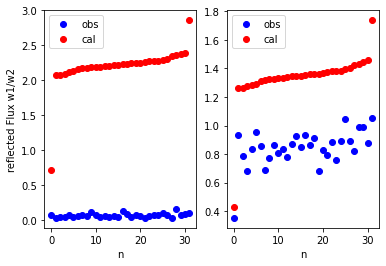

In [374]:
y0 = obsdat12
fluxRef1 = calFref(200,delta_N[0:32],d_N[0:32],alpha_N[0:32],3.4e-6,epsi)
fluxRef2 = calFref(100,delta_N[32:64],d_N[32:64],alpha_N[32:64],4.6e-6,epsi)
fluxRefATM = calcFluxLambdaAtObsWithSunlight(d_N, delta_N, 1.2e-6, 346, alpha_N, 0.9, G,Hv)
plt.subplot(1,2,1)
plt.plot(y0[0:32],'bo',label = 'obs')
plt.plot(fluxRef1,'ro',label = 'cal')
plt.legend() 
plt.xlabel("n")
plt.ylabel("reflected Flux w1/w2");
plt.subplot(1,2,2)
plt.plot(y0[32:64],'bo',label = 'obs')
plt.plot(fluxRef2,'ro',label = 'cal')
plt.legend() 
plt.xlabel("n")

##### cal $F_v^{th}$ in W1/W2 

/tmp/ipykernel_298786/3361495899.py:15: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)


Text(0.5, 0, 'n')

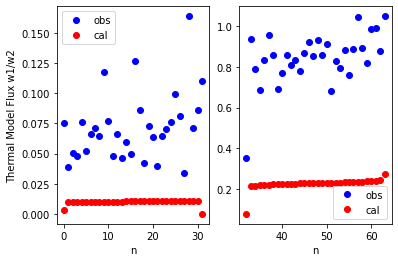

In [366]:
y = obsdat12
nt = np.arange(len(d_N))
theta = [3.4,346]
flux12 = Model_neatm_ohhq(theta,x=(delta_N,d_N,alpha_N),lamda=[3.4,4.6])
plt.subplot(1,2,1)
plt.plot(nt[0:32],obsdat12[0:32],'bo',label = 'obs')
plt.plot(nt[0:32],flux12[0:32],'ro',label = 'cal')
plt.legend() 
plt.xlabel("n")
plt.ylabel("Thermal Model Flux w1/w2");
plt.subplot(1,2,2)
plt.plot(nt[32:64],obsdat12[32:64],'bo',label = 'obs')
plt.plot(nt[32:64],flux12[32:64],'ro',label = 'cal')
plt.legend() 
plt.xlabel("n")

##### cal $F_v^{th}+F_v^{ref}$ in W1\W2

Text(0.5, 0, 'n')

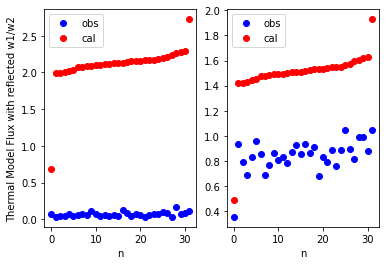

In [367]:
flux01 = flux12[0:32]+fluxRef1
flux02 = flux12[32:64]+fluxRef2
plt.subplot(1,2,1)
plt.plot(y0[0:32],'bo',label = 'obs')
plt.plot(flux01,'ro',label = 'cal')
plt.legend()
plt.xlabel("n")
plt.ylabel("Thermal Model Flux with reflected w1/w2");
plt.subplot(1,2,2)
plt.plot(y0[32:64],'bo',label = 'obs')
plt.plot(flux02,'ro',label = 'cal')
plt.legend() 
plt.xlabel("n")

##### cal $F_v^{th}$ in W3\W4

/tmp/ipykernel_298786/3361495899.py:15: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)


Text(0.5, 0, 'n')

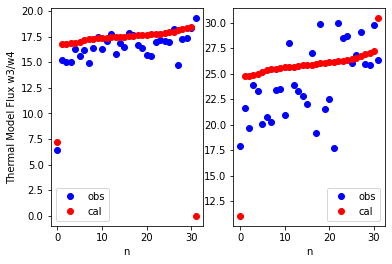

In [368]:
y = obsdat34
nt = np.arange(len(d_N))
theta = [3.4,346]
flux34 = Model_neatm_ohhq(theta,x=(delta_N,d_N,alpha_N),lamda=lamdai)
plt.subplot(1,2,1)
plt.plot(y[0:32],'bo',label = 'obs')
plt.plot(flux34[0:32],'ro',label = 'cal')
plt.legend()
plt.xlabel("n")
plt.ylabel("Thermal Model Flux w3/w4");
plt.subplot(1,2,2)
plt.plot(y[32:64],'bo',label = 'obs')
plt.plot(flux34[32:64],'ro',label = 'cal')
plt.legend() 
plt.xlabel("n")


##### cal $F_v^{ref}$ in W3/W4

[0.07233356 0.21135411 0.21135563 0.21293413 0.21452864 0.21613935
 0.21941168 0.22024057 0.22107209 0.22190945 0.22274945 0.22275107
 0.22359537 0.2244456  0.22529852 0.22530016 0.22615745 0.22702077
 0.22788683 0.22788851 0.228759   0.22963564 0.23051506 0.23051677
 0.2314007  0.23318389 0.23408323 0.23772523 0.23957355 0.24144093
 0.24332942 0.29018488]


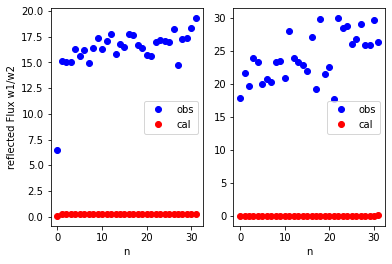

In [369]:
fluxRef341 = calFref(346,delta_N[0:32],d_N[0:32],alpha_N[0:32],12e-6,epsi)
fluxRef342 = calFref(346,delta_N[32:64],d_N[32:64],alpha_N[32:64],22e-6,epsi)
plt.subplot(1,2,1)
plt.plot(y[0:32],'bo',label = 'obs')
plt.plot(fluxRef341,'ro',label = 'cal')
plt.legend() 
plt.xlabel("n")
plt.ylabel("reflected Flux w1/w2");
plt.subplot(1,2,2)
plt.plot(y[32:64],'bo',label = 'obs')
plt.plot(fluxRef342,'ro',label = 'cal')
plt.legend() 
plt.xlabel("n")
print(fluxRef341)